<a href="https://colab.research.google.com/github/braveenth/garmin-running-llm/blob/main/Garmin_Running_LLM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garmin Running LLM Analysis 🏃
By: Braveenth Rasanayagam

---

The goal of this Jupyter Notebook is to have reuseable code that facilitates the prompting and analysis of your your Garmin-tracked runs by LLMs.

This was built to help train for a half-marathon, and you can use it for your fitness activities.

I solved the context length limitations imposed by various LLM models by splitting the data using even rows, which is a method to reduce the number of data points. I am also considering other mathematical methods of reducing the number of data points.

Please note that I am not responsible or liable for your use of this application. Please use this at your own risk and consult with a health care professional.


## Steps to Use:
Using OpenAI's ChatGPT API:

1.   Obtain an OpenAI API Key here: https://platform.openai.com/api-keys
2.   Add OpenAI API Key as a Colab secret value named 'OPENAI_API_KEY'
3.   Obtain .fit file from Garmin Connect
4.   Upload .fit file to Colab files
5.   Specify path to .fit file in notebook form

## Steps to Contribute:
Submit a pull-request or message me!
MIT License

## Additional Links
*   [runw.ai](https://www.runw.ai/)
*   [Instagram - runw.ai](https://www.instagram.com/runw.ai.run/)


In [5]:
!pip install garmin-fit-sdk
!pip install tiktoken
!pip install openai

In [6]:
# Lets start by obtaining the path to the .fit file
fit_file = "/content/14820637941_ACTIVITY.fit" # @param {type:"string"}

In [8]:
# This is for when the program runs outside of Colab

import os
from openai import OpenAI
colabEnvironment = False

try:
    # Attempt to import the google.colab module to see if the program is running in Colab.
    from google.colab import userdata
    print("Running on Google Colab")
    colabEnvironment = True
    openai_api_key = userdata.get('OPENAI_API_KEY')
    client = OpenAI(api_key=openai_api_key)

except ImportError:
    # The ImportError exception will be raised if the google.colab module is not found,
    # indicating that the program is not running inside Google Colab.
    print("Running outside of Google Colab")
    openai_api_key = os.environ['OPENAI_API_KEY']
    client = OpenAI(api_key=openai_api_key)
    fit_file = os.environ.get('FIT_FILE_PATH')

Running on Google Colab


In [10]:
# Lets describe an existing run that I have completed. We will use the fit file from Garmin Connect.
# In the future, we will retrieve this using Garmin's API.
# Lets use the garmin-fit-sdk here

from garmin_fit_sdk import Decoder, Stream

stream = Stream.from_file(fit_file)
decoder = Decoder(stream)
messages, errors = decoder.read()

print(errors)
# print(messages)

[]


In [11]:
file_messages = messages['file_id_mesgs']

duration_of_activity = messages['activity_mesgs'][0]['total_timer_time']
activity_record_messages = messages['record_mesgs']

# for activity_message in activity_record_messages:
#   print(activity_message)
#print(messages['user_profile_mesgs'])
#print(messages['file_id_mesgs'])

# Information about the units
# 'distance' - metres

In [12]:
# Lets get this information into a Pandas Dataframe

import pandas as pd

df = pd.DataFrame(activity_record_messages)
# Lets remove columns that are currently not necessary

df_with_relevant_information = df.drop(['cycle_length16', 'enhanced_speed','fractional_cadence', 135, 136], axis=1)
display(df_with_relevant_information)

,timestamp,distance,heart_rate,cadence,temperature
0,2024-04-09 19:25:46+00:00,1.20,74,0,28
1,2024-04-09 19:25:48+00:00,3.61,77,0,28
2,2024-04-09 19:25:53+00:00,9.63,81,72,28
3,2024-04-09 19:25:57+00:00,14.45,78,72,28
4,2024-04-09 19:26:00+00:00,18.05,75,72,28
...,...,...,...,...,...
562,2024-04-09 20:15:40+00:00,6456.93,164,49,28
563,2024-04-09 20:15:46+00:00,6464.64,164,54,28
564,2024-04-09 20:15:52+00:00,6469.60,162,0,28
565,2024-04-09 20:15:58+00:00,6469.60,162,55,28


In [13]:
# Lets use the timestamp to get additional information

df2 = df_with_relevant_information

startDateTime = df.iloc[0]['timestamp']
endDateTime = df.iloc[-1]['timestamp']
print(startDateTime)
print(endDateTime)

time_diff = endDateTime - startDateTime
print(time_diff)
#df2['Time (min)'] = df2['timestamp']
#df2['Pace (min/km)'] = df2['Time (min)'] / df2['Distance (km)']

df2['seconds'] = df['timestamp'].astype('int64') // 1e9

specific_value3 = df2.loc[0, 'seconds']
print(specific_value3)
df2['activity_duration_seconds'] = df2['seconds'] - specific_value3


#display(df2)

df_original = df2.drop(['timestamp', 'seconds'], axis=1)
#display(df3)


2024-04-09 19:25:46+00:00
2024-04-09 20:15:59+00:00
0 days 00:50:13
1712690746.0


In [14]:
# Lets calculate Derivatives here
import numpy as np

# 1. Distance and Speed
#    First Derivative (Velocity)
df_original['velocity'] = np.gradient(df_original['distance'], df_original['activity_duration_seconds'])

#    Second Derivative (Acceleration)
df_original['acceleration'] = np.gradient(df_original['velocity'], df_original['activity_duration_seconds'])


# 2. Heart Rate Dynamics
#    First Derivative
df_original['heart_rate_dynamics'] = np.gradient(df_original['heart_rate'], df_original['activity_duration_seconds'])


# 3. Cadence Variability
#    First Derivative
df_original['cadence_variability'] = np.gradient(df_original['cadence'], df_original['activity_duration_seconds'])


# 4. Temperature Effects
#    First Derivative
df_original['temperature_effects'] = np.gradient(df_original['temperature'], df_original['activity_duration_seconds'])


display(df_original)

,distance,heart_rate,cadence,temperature,activity_duration_seconds,velocity,acceleration,heart_rate_dynamics,cadence_variability,temperature_effects
0,1.20,74,0,28,0.0,1.205000e+00,-1.428571e-04,1.500000,0.000000,0.000000e+00
1,3.61,77,0,28,2.0,1.204714e+00,-1.111111e-04,1.300000,4.114286,2.220446e-16
2,9.63,81,72,28,7.0,1.204556e+00,-3.492063e-04,-0.061111,6.400000,0.000000e+00
3,14.45,78,72,28,11.0,1.202143e+00,-3.492063e-04,-0.892857,0.000000,0.000000e+00
4,18.05,75,72,28,14.0,1.201667e+00,3.306878e-05,-0.611111,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
562,6456.93,164,49,28,2994.0,1.420833e+00,-4.270833e-02,-0.166667,-0.583333,0.000000e+00
563,6464.64,164,54,28,3000.0,1.055833e+00,-8.395833e-02,-0.166667,-4.083333,0.000000e+00
564,6469.60,162,0,28,3006.0,4.133333e-01,-8.798611e-02,-0.166667,0.083333,0.000000e+00
565,6469.60,162,55,28,3012.0,-9.094947e-13,-9.841270e-03,0.000000,1.309524,-3.552714e-15


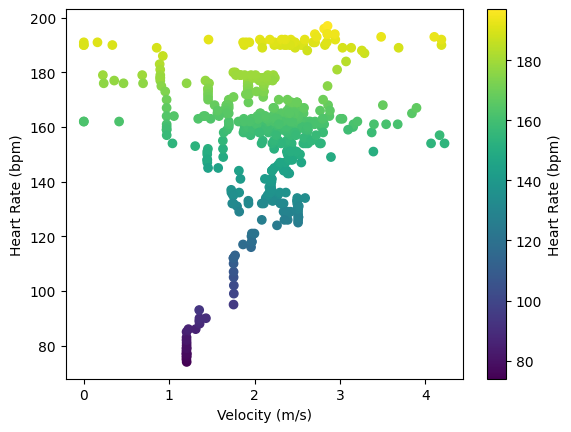

In [15]:
# @title Velocity vs Heart Rate

import matplotlib.pyplot as plt
plt.scatter(df_original['velocity'], df_original['heart_rate'], c=df_original['heart_rate'], cmap='viridis')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Heart Rate (bpm)')
_ = plt.colorbar(label='Heart Rate (bpm)')

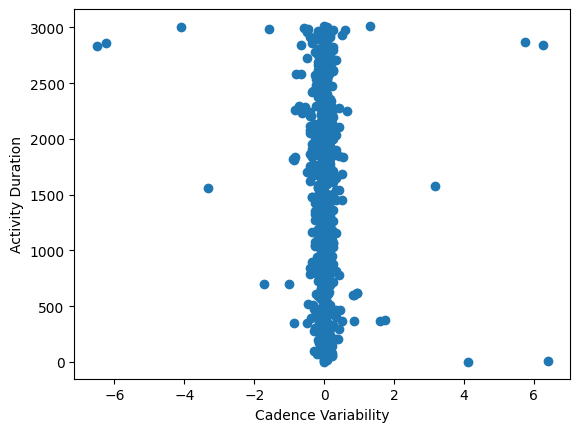

In [16]:
# @title Cadence Variability vs Activity Duration

import matplotlib.pyplot as plt
plt.scatter(df_original['cadence_variability'], df_original['activity_duration_seconds'])
plt.xlabel('Cadence Variability')
_ = plt.ylabel('Activity Duration')

In [17]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo-16k")


# Get the Dataframe to a String
df_string = df_original.to_string()
print ("Number of tokens in input prompt ", len(enc.encode(df_string)))

#Lets get the token size to be appropriate
# The iloc operation will allow us to select rows at specified internals.
# If we use iloc[::2], this is a slicing option to include every other row
# starting from the first row.

target_tokens = 14000
df_token_limitation = df_original

while(len(enc.encode(df_token_limitation.to_string())) > target_tokens):
  df_token_limitation = df_token_limitation.iloc[::2]

display(df_token_limitation)

df_reduced_string = df_token_limitation.to_string()
print ("Number of tokens in resized input prompt ", len(enc.encode(df_reduced_string)))

Number of tokens in input prompt  38016


,distance,heart_rate,cadence,temperature,activity_duration_seconds,velocity,acceleration,heart_rate_dynamics,cadence_variability,temperature_effects
0,1.20,74,0,28,0.0,1.205000,-1.428571e-04,1.500000,0.000000,0.000000e+00
4,18.05,75,72,28,14.0,1.201667,3.306878e-05,-0.611111,0.000000,0.000000e+00
8,46.94,77,73,28,38.0,1.203333,6.944444e-05,0.250000,0.000000,0.000000e+00
12,74.63,83,75,28,61.0,1.203697,1.804112e-16,0.587879,0.218182,0.000000e+00
16,100.24,86,74,28,82.0,1.310833,1.093056e-02,0.166667,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
548,6328.41,170,67,27,2912.0,1.455833,6.388889e-03,-0.250000,0.166667,0.000000e+00
552,6366.84,168,68,28,2936.0,1.672500,9.464651e-15,-0.083333,0.166667,8.333333e-02
556,6406.92,165,66,28,2960.0,1.565000,-2.222222e-02,-0.083333,-0.500000,8.333333e-02
560,6438.11,164,68,28,2982.0,1.584500,1.372222e-02,0.283333,-0.466667,-4.440892e-16


Number of tokens in resized input prompt  8696


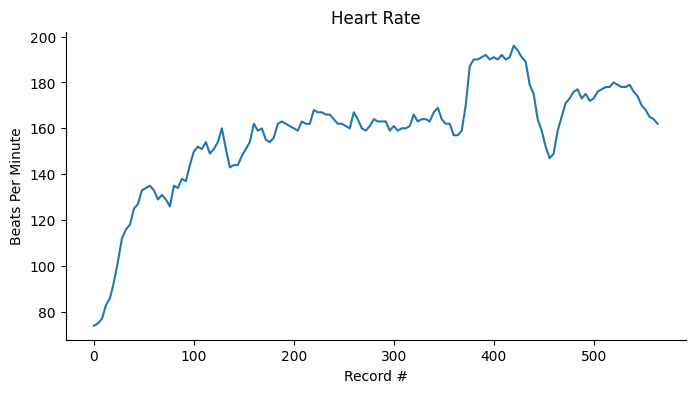

In [18]:
# @title Heart Rate

from matplotlib import pyplot as plt
df_token_limitation['heart_rate'].plot(kind='line', figsize=(8, 4), title='Heart Rate')
plt.xlabel('Record #')
plt.ylabel('Beats Per Minute')
plt.gca().spines[['top', 'right']].set_visible(False)

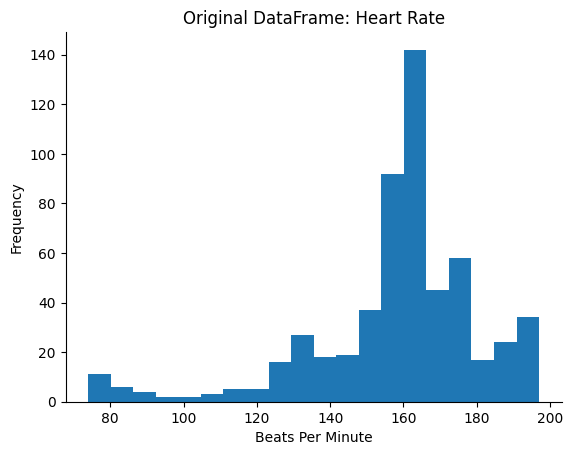

In [19]:
# Visualize Pace from original DF
from matplotlib import pyplot as plt
df['heart_rate'].plot(kind='hist', bins=20, title='Original DataFrame: Heart Rate')
plt.xlabel('Beats Per Minute')
plt.gca().spines[['top', 'right',]].set_visible(False)

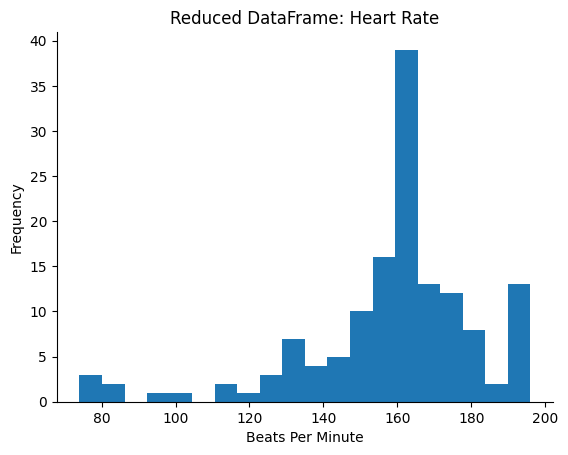

In [20]:
# Visualize Heart Rate Data from the reduced DF
df_token_limitation['heart_rate'].plot(kind='hist', bins=20, title='Reduced DataFrame: Heart Rate')
plt.xlabel('Beats Per Minute')
plt.gca().spines[['top', 'right',]].set_visible(False)

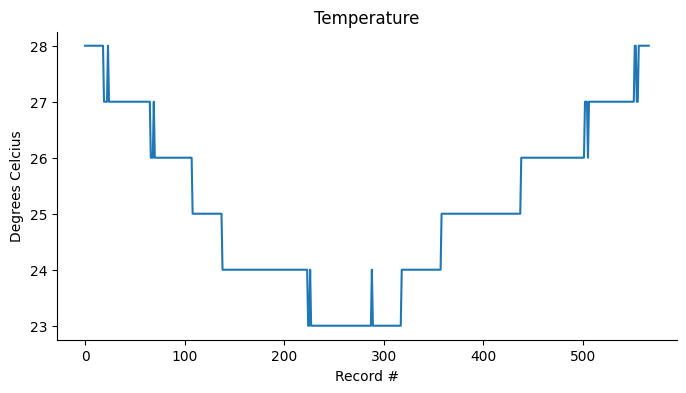

In [21]:
# @title Temperature Over Time Original Dataframe

from matplotlib import pyplot as plt
df['temperature'].plot(kind='line', figsize=(8, 4), title='Temperature')
plt.xlabel('Record #')
plt.ylabel('Degrees Celcius')
plt.gca().spines[['top', 'right']].set_visible(False)

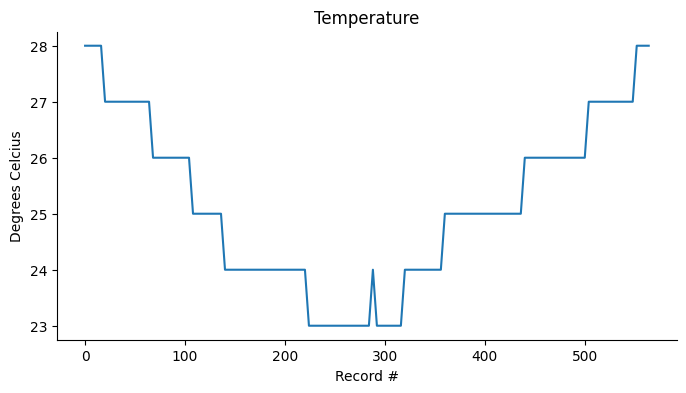

In [22]:
# @title Temperature Over Time Reduced Dataframe

from matplotlib import pyplot as plt
df_token_limitation['temperature'].plot(kind='line', figsize=(8, 4), title='Temperature')
plt.xlabel('Record #')
plt.ylabel('Degrees Celcius')
plt.gca().spines[['top', 'right']].set_visible(False)

In [23]:
df_for_llm = df_token_limitation

from openai import OpenAI

try:
    # Attempt to import the google.colab module to see if the program is running in Colab.
    from google.colab import userdata
    print("Running on Google Colab")
    client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

except ImportError:
    # The ImportError exception will be raised if the google.colab module is not found,
    # indicating that the program is not running inside Google Colab.
    import os
    print("Running outside of Google Colab")
    openai_api_key = os.environ['OPENAI_API_KEY']
    client = OpenAI(api_key=openai_api_key)

import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo-16k")

# Get the Dataframe to a String
df_string = df_for_llm.to_string()
print ("Number of tokens in input prompt ", len(enc.encode(df_string)))


Running on Google Colab
Number of tokens in input prompt  8696


In [37]:
# Manual Calculations using Math

#1. Distance in kilometers
#2. Time in hours:minutes
#3. Average Pace in minutes/km

activity_distance_metres = df_for_llm['distance'].max()
activity_distance_kilometers = activity_distance_metres / 1000
activity_time_seconds = df_for_llm['activity_duration_seconds'].max()
activity_time_minutes = activity_time_seconds / 60
activity_pace = activity_time_minutes /activity_distance_kilometers

print(activity_distance_kilometers)
print(activity_time_minutes)
print(activity_pace)

6.469600000000001
50.1
7.743909978978607


In [38]:
instructPrompt = f"""
You are an expert running coach and you are able to summarize running workout data that was captured from a Garmin wearable device. The 'distance' is in metres.
You will provide 5 key takeaways for the treadmill running data that is provided, ordered as a list from 1 to 5.
You will also provide recommendations and affirmations on how to get better at these running workouts.
Please summarize the dataset that is represented as a string from a Pandas DataFrame.
You will also provide the following information as a table:
1. Distance in kilometers
2. Time in hours:minutes
3. Average Pace in minutes/km

From performing calculations, we already know the following:
1. Distance in kilometers is {activity_distance_kilometers}
2. Time in minutes is {activity_distance_kilometers}
3. Average Pace in minutes/km is {activity_pace}

Use this information to calibrate yourself.

The dataset is provided below"""

request = instructPrompt + df_string

In [39]:
chatOutput = client.chat.completions.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )

In [40]:
runningSummary = chatOutput.choices[0].message.content
print(runningSummary)

Summary of Treadmill Running Data:

Key Takeaways:
1. Distance: The total distance covered during the running workout is 6.4696 kilometers.
2. Heart Rate: The average heart rate during the workout ranged from 74 to 196 beats per minute.
3. Cadence: The average running cadence varied between 0 and 84 steps per minute.
4. Temperature: The temperature during the workout remained constant at 24-28 degrees Celsius.
5. Duration: The total duration of the running workout was 3006 seconds.

Recommendations:
1. Increase Distance: To improve your running workouts, gradually increase the distance covered over time.
2. Monitor Heart Rate: Pay attention to your heart rate during workouts and try to maintain it within a target range for optimal training.
3. Work on Cadence: Focus on increasing your running cadence to improve overall running efficiency and reduce the risk of injury.
4. Stay Hydrated: Make sure to drink enough fluids before, during, and after your workouts to stay properly hydrated.
5

In [43]:
instructPromptForMetrics = f"""

You are an expert running coach and you are able to summarize running workout data that was captured from a Garmin wearable device. The 'distance' is in metres.
Please obtain the following information from the dataset that is represented as a string from a Pandas DataFrame. Some of the values have already been calculated, and are accurate:

1. Distance in kilometers, which we know is {activity_distance_kilometers}
2. Average Pace in minutes/km, which we know is {activity_pace}
3. Heart Rate, which is 'heart_rate' in the DataFrame. We know the average is {df_for_llm['heart_rate'].mean()}
4. Maximum Heart Rate, which is 'heart_rate' in the DataFrame. We know the average is {df_for_llm['heart_rate'].max()} beats per minute.
5. Elevation Gain in metres if it exist.
6. Temperature in degrees celcius, which we know the average is {df_for_llm['temperature'].mean()}
7. Maximum Temperature in degrees celcius, which we know the average is {df_for_llm['temperature'].max()}

You will return this as an ordered as a list from 1 to 5. Only provide the summarized information.

The dataset is provided below"""

requestForMetrics = df_string + instructPromptForMetrics

In [45]:
chatOutputForMetrics = client.chat.completions.create(model="gpt-4-0125-preview",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": requestForMetrics}
                                                      ]
                                            )

In [46]:
metricsSummary = chatOutputForMetrics.choices[0].message.content
print(metricsSummary)

Based on the information and calculations provided from the dataset:

1. Distance in kilometers: 6.4696 km
2. Average Pace: 7.744 minutes/km
3. Average Heart Rate: 157.89 bpm
4. Maximum Heart Rate: 196 bpm
5. Average Temperature: 25.16°C
6. Maximum Temperature: 28°C

Note: Elevation Gain information is not present in the provided data snippet, therefore, it cannot be summarized.


In [48]:
# Podcast title: "Running with Resilience"
instructPromptForAudio = """
Given metrics from a recent run, generate a 1-minute long podcast script. The title of the podcast is 'Running with Resilience.'
Your name is Terry, and you are an expert running coach. Provide an enthusiastic and motivational analysis of their performance, focusing on distance, pace, heart rate, and elevation gain. Include personalized affirmations and encouragement, emphasizing improvement and resilience. Keep the tone optimistic, supportive, and empowering, making the user feel celebrated for their achievements and motivated to continue their running journey."

Instructions:

1. Begin with a Warm Welcome: Start the podcast by greeting the listener and introducing yourself as their running coach. Express excitement about sharing their recent run achievements.
2. Analyze Performance Metrics:
    2.1. Distance: Commend the user on the distance covered, relating it to their dedication and progress.
    2.2. Pace: Reflect on the importance of consistency in pace, encouraging the user to keep moving forward at their own rhythm.
    2.3. Heart Rate: Highlight the effort shown by the heart rate data, connecting physical health to mental resilience.
    2.4. Elevation Gain: Use elevation gain to discuss overcoming challenges, likening hills to life's obstacles that the user is capable of conquering.
3. Incorporate Affirmations: Throughout the analysis, weave in affirmations such as "You are strong", "You are resilient", and "Every step is a victory". Encourage the listener to repeat these affirmations to foster a positive mindset.
4. Conclude with Motivational Encouragement: End the podcast by summarizing the user's achievements, reinforcing their potential for growth, and motivating them to continue their running journey. Encourage them to look forward to their next run with optimism and determination.
5. Keep It Brief and Engaging: Ensure the script is concise enough to fit into a 1-minute segment while being engaging and motivational.
6. Make it one entire transcript with only 1 host speaking. You will only provide what the host will say, and nothing else.
7. Do not use [User's average pace] or any variable names in brackets. Use actual metrics instead of placeholders.
Output Format:

A script suitable for a 1-minute podcast segment, formatted with clear sections for the introduction, analysis of each metric, affirmations, and a motivational conclusion.

The dataset is provided below"""

requestForAudio = metricsSummary + instructPromptForAudio

In [49]:
chatOutputForAudio = client.chat.completions.create(model="gpt-4",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": requestForAudio}
                                                      ]
                                            )

In [50]:
runningSummaryForAudio = chatOutputForAudio.choices[0].message.content
print(runningSummaryForAudio)

"Hello, Resilient Runners! It's Terry, your running coach, here to celebrate your recent running achievements. You're constantly moving forward, and today, we're going to celebrate your progress.

You've covered an impressive 6.4696 kilometers! Wow, talk about dedication! Remember, every kilometer is a testament to your commitment and a symbol of your strength. 

Keeping a consistent pace is key to a successful run, and boy, you did just that! Your average pace of 7.744 minutes per kilometer shows that you've found your rhythm. Always remember, it's not about speed, it’s about sustainability. You are capable and your pace perfect just as it is.

Your heart rate data speaks volumes about your effort. With an average heart rate of 157.89 beats per minute and a maximum of 196, you really put your heart into every stride. This shows your physical strength and the mental resilience that's inherent within you.

Even though we lack the data about elevation gain today, I've seen you face uphil

In [51]:
import re

def remove_text_inside_brackets(text):
    # This pattern matches anything inside square brackets, including the brackets themselves.
    # It accounts for nested brackets as well.
    pattern = r'\[.*?\]'
    # Replace anything that matches the pattern with an empty string.
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

first_pass_text = remove_text_inside_brackets(runningSummaryForAudio)


def remove_host_instances(text):
    # This pattern matches the exact string "Host:".
    pattern = r'Host:'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

second_pass_text = remove_host_instances(first_pass_text)

def remove_empty_lines(text):
    # Split the text into lines, filter out empty or whitespace-only lines, and join back into a single string
    cleaned_text = "\n".join(line for line in text.splitlines() if line.strip())
    return cleaned_text


final_pass_text = remove_empty_lines(second_pass_text)
print(final_pass_text)

"Hello, Resilient Runners! It's Terry, your running coach, here to celebrate your recent running achievements. You're constantly moving forward, and today, we're going to celebrate your progress.
You've covered an impressive 6.4696 kilometers! Wow, talk about dedication! Remember, every kilometer is a testament to your commitment and a symbol of your strength. 
Keeping a consistent pace is key to a successful run, and boy, you did just that! Your average pace of 7.744 minutes per kilometer shows that you've found your rhythm. Always remember, it's not about speed, it’s about sustainability. You are capable and your pace perfect just as it is.
Your heart rate data speaks volumes about your effort. With an average heart rate of 157.89 beats per minute and a maximum of 196, you really put your heart into every stride. This shows your physical strength and the mental resilience that's inherent within you.
Even though we lack the data about elevation gain today, I've seen you face uphill ch

In [52]:
from pathlib import Path
from openai import OpenAI
import datetime

date = datetime.datetime.now().strftime("%Y-%m-%d")
file_name = "podcast_"+ date +".mp3"
file_path_name = "/content/" + file_name

audioClient = OpenAI(api_key=openai_api_key)

speech_file_path = file_path_name
response = audioClient.audio.speech.create(
  model="tts-1",
  voice="echo",
  input=final_pass_text
)

response.stream_to_file(speech_file_path)

<ipython-input-52-1c3e8b2496c3>:18: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(speech_file_path)


# Use Cloud Storage to Store the Files




In [53]:
# Authenticate.

# if colabEnvironment == True:
#     from google.colab import auth
#     auth.authenticate_user()
#     # Install Cloud Storage FUSE.
#     !echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
#     !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
#     !apt -qq update && apt -qq install gcsfuse

#     # Mount a Cloud Storage bucket or location, without the gs:// prefix.
#     mount_path = "running-llm-podcast"  # or a location like "my-bucket/path/to/mount"
#     local_path = f"/mnt/gs/{mount_path}"

#     !mkdir -p {local_path}
#     !gcsfuse --implicit-dirs {mount_path} {local_path}

In [56]:
# if colabEnvironment == True:
    #!mv "/content/podcast.mp3" {file_path_name}
    # !cp {file_path_name} {local_path}
    #!ls -lh {local_path}